In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob as glob
import random
import cv2
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# from tqdm import tqdm
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F

from torch.utils.data import Dataset
from torchvision import io, datasets, models, transforms

random.seed(0)
torch.manual_seed(0)

In [2]:
os.getcwd()

'/home/anhnguyen/Documents/testSOTACrackClassification/models/training'

In [3]:
data_dir = '../../datasets'
img_data_roots = [
    '/AEL/test_img',
    '/CFD/test_img',
    '/CrackTree200/test_img',
    '/CRACK500/test_img',
    '/GAPs384/test_img'
]
    
X = []
for path in img_data_roots:
    X.extend(glob.glob(f'{data_dir}/{path}/**/*.jpg', recursive = True))
y = [1 for x in range(len(X))]

In [4]:
#create dataset from dataframe
class CrackDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = torch.tensor(self.y[idx],dtype=torch.long)
        
        img_path = self.X[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if(img.shape[:2] != (224,224)):
            img = cv2.resize(img,(224,224))
        
        img = Image.fromarray(np.uint8(img)).convert('RGB')

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

In [5]:
from sklearn.model_selection import train_test_split  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

data_transforms = {
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
#         normalize
    ]),
}

#load data from a list of paths
image_datasets = {
    'test': 
    CrackDataset(X, y, transforms=data_transforms['validation'])
}

batch_size = 1
num_workers = 1
dataloaders = {
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers),
}



cuda:0


In [6]:
#Model define
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = 'cpu'
# model = models.mobilenet_v2(pretrained=False, progress=False).to(device)
num_classes = 2

cuda:0


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues, save_path = None):
    #cm output from sklearn.confusion_matrix
    fig, ax = plt.subplots(figsize = (5,5))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j], 2),
                          ha="center", va="center", color="k")
    plt.title(title)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save_path == None:
        plt.show()
    else:
        plt.savefig(save_path, facecolor = 'white')

def iou(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    
def evaluate(y_truth, y_pred, labels, 
        save_confusion_matrix_path = 'evaluation_results/sample.png', 
        save_classification_report_path = 'evaluation_results/sample.csv'
        ): 
    labels = [str(x) for x in labels]

    print('Classification Report')
    cls_report = classification_report(y_truth, y_pred,labels = [x for x in range(len(labels))], target_names=labels)
    if save_classification_report_path != None:
        df = pd.DataFrame(cls_report).transpose()
        df.to_csv(save_classification_report_path)
    print(cls_report)

    print('Confusion Matrix')
    plot_confusion_matrix(confusion_matrix(y_truth, y_pred, normalize = 'true'), labels = labels, save_path = save_confusion_matrix_path)

    
model_save_path = "weights"


In [9]:
#Evaluation model with 200 epochs on both train and val dataset
model_trained = torch.load(f'{model_save_path}/model.pth')
model_trained.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

EVALUATE Other segmentation dataset

cuda:0


  0%|          | 0/4255 [00:00<?, ?it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.64      0.78      4255

    accuracy                           0.64      4255
   macro avg       0.50      0.32      0.39      4255
weighted avg       1.00      0.64      0.78      4255

Confusion Matrix


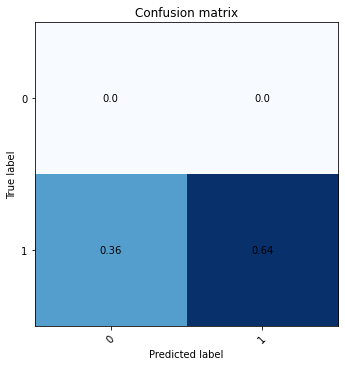

In [10]:
#Eval best model
model_trained = torch.load(f'{model_save_path}/model.pth')
model_trained.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Inference
model_trained.eval().to(device)
pred_c = np.array([])
label_c = np.array([])

for inputs, labels in tqdm(dataloaders['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    label_c = np.concatenate((label_c, labels.cpu().numpy()))
    pred_c = np.concatenate((pred_c, preds.data.cpu().numpy()))
labels = ['0', '1'] 
evaluate(label_c, pred_c, labels, 
        save_confusion_matrix_path = 'evaluation/segmentDataset_test_best_model.png', 
        save_classification_report_path = None,
        )